# Interfacing with Stan
This notebook explains how it is possible to interface with [Stan](https://mc-stan.org/) to make use of their awesome library for log-probability calculations, gradient calculation (via autodiff) and their large zoo of probability distributions.

One thing to be mindful of is that the interface below only allows the log probability to be accessed from Stan objects up to an additive constant.

In this notebook, we use the [Eight Schools example](http://pints.readthedocs.io/en/latest/toy/eight_schools.html) and show how the model can be defined in Stan but called from in Pints.

In [1]:
import pystan

In [2]:
code1 = """
data {
  int N;
  real y[N];
}

parameters{
  real mu;
  real<lower=0> sigma;
}

model {
  y ~ normal(mu, sigma);
  mu ~ normal(0, 5);
  sigma ~ cauchy(0, 5);
}
"""

In [3]:
import scipy.stats
N = 20
y = scipy.stats.norm.rvs(0, 1, N)

In [5]:
stanmodel = pints.interfaces.StanLogPDF(stan_code=code1,
                                        stan_data={'N': N, 'y': y},
                                        pickle_filename="normal_model.pkl")

Stan model compiled and runs ok...ignore various warnings.


/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


In [6]:
class SimpleGaussian(pints.LogPDF):
    def __init__(self, y):
        self._prior1 = pints.GaussianLogPrior(0, 5)
        self._prior2 = pints.HalfCauchyLogPrior(0, 5)
        self._y = y

    def __call__(self, x):
        pdf = pints.GaussianLogPrior(x[0], x[1])
        lp = sum([pdf([y]) for y in self._y])
        return lp + self._prior1([x[0]]) + self._prior2([x[1]])

    def n_parameters(self):
        return 2

pintsmodel = SimpleGaussian(y=y)

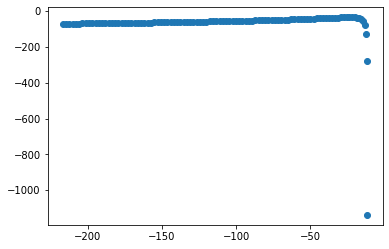

In [9]:
# mus = np.linspace(-10, 10, 100)
taus = np.linspace(0.1, 10, 100)
vals_stan = []
vals_pints = []
for tau in taus:
    a_params = [0, tau]
    vals_stan.append(stanmodel(a_params))
    vals_pints.append(pintsmodel(a_params))
plt.plot(vals_stan, vals_pints, 'o')
plt.show()

In [19]:
stanmodel([0, np.exp(-2)])

-11.613389782901098

In [8]:
np.corrcoef(vals_stan, vals_pints)

array([[1.        , 0.99999998],
       [0.99999998, 1.        ]])

Define Stan model using their syntax.

In [2]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

## Centered model

Import the Eight Schools ("centered" parameterisation) model from Pints: just to provide the data for fitting the Stan model in Pints.

In [4]:
import os
os.chdir("../../")
import pints
import pints.toy
import pints.interfaces
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats

model = pints.toy.EightSchoolsLogPDF()

Use Pints' interface to Stan's models to compile the Stan code and define a Pints model. Also, pickle the model so that it can be reloaded for later use.

In [4]:
# instantiate Pints version of Stan model
stanmodel = pints.interfaces.StanLogPDF(stan_code=code,
                                        stan_data=model.data(),
                                        pickle_filename="test_model.pkl")

Stan model compiled and runs ok...ignore various warnings.


/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Run [relativistic HMC](../sampling/relativistic-mcmc.ipynb) sampler using this model.

In [6]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.0
3     244    0.6       0.6       0.6       0.6        0:00.0
400   32004  0.988     0.893     0.993     0.993      0:03.5
800   64004  0.994     0.918     0.995     0.995      0:07.0
1200  96004  0.996     0.945     0.993     0.997      0:10.5
1600  128004  0.994382  0.959     0.976     0.998      0:14.0
2000  159924  0.996     0.967     0.97      0.998001   0:17.5
Halting: Maximum number of iterations (2000) reached.
Done!


In [7]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start), parameter_names=stanmodel.names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
mu       2.94    1.61    -0.12   1.79   2.94   4.03   6.05     1.19    34.07  1.94
tau      0.11    1.39    -3.12   -0.68  0.36   1.21   2.05     1.48    37.67  2.15
theta.1  3.64    2.67    -0.62   1.76   3.26   5.06   10.62    1.23    28.40  1.62
theta.2  2.87    2.73    -3.09   1.29   3.04   4.74   7.81     1.14    38.40  2.19
theta.3  2.17    3.05    -5.41   0.83   2.60   4.27   6.84     1.55    27.31  1.56
theta.4  2.90    2.88    -5.01   1.53   3.02   4.59   8.09     1.25    33.58  1.92
theta.5  1.94    2.64    -4.24   0.53   2.17   3.62   6.36     1.33    43.70  2.49
theta.6  3.22    2.39    -0.93   1.55   3.12   4.67   8.65     1.10    41.13  2.35
theta.7  3.62    2.68    -1.67   1.89   3.54   5.21   9.50     1.18    30.48  1.74
theta.8  4.00    3.46    -0.58   1.58   3.21   5.31   13.47    1.41  

The wandering chains here illustrate how difficult inference is for this model.

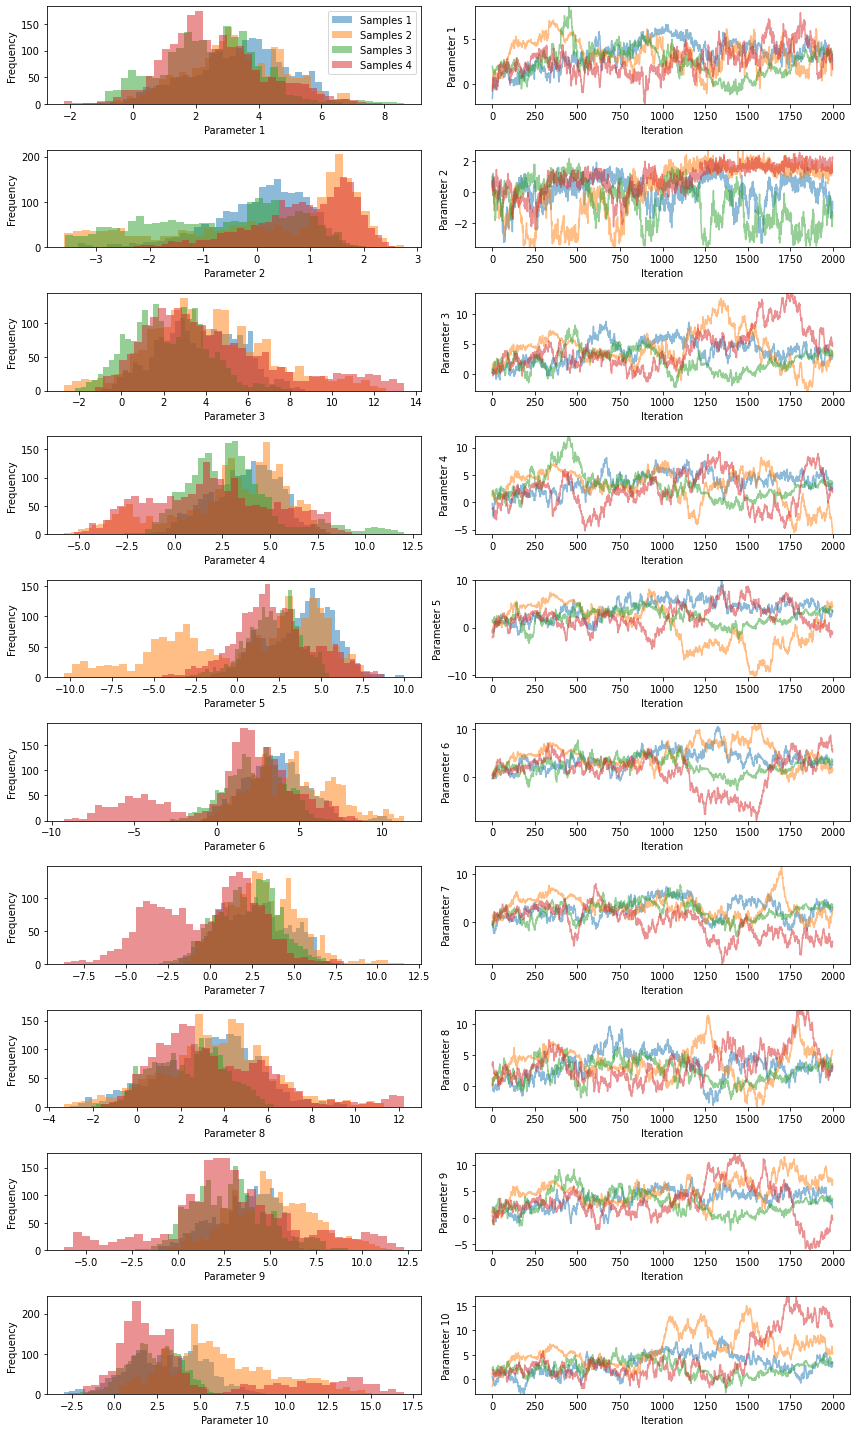

In [8]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Just to hammer home the differences between Stan's log probability and Pints': we can compare them for sets of parameter values.

In [5]:
params = np.random.uniform(size=10)

pintsmodel = pints.toy.EightSchoolsLogPDF()

print(str("Stan log prob: " + str(stanmodel(params))))
print(str("Pints log prob: " + str(pintsmodel(params))))

Stan log prob: -7.3738301564794
Pints log prob: -38.583181088360476


The same goes for sensitivities!

In [6]:
p1, dp1 = stanmodel.evaluateS1(params)
p2, dp2 = pintsmodel.evaluateS1(params)

print(str("Stan d log(prob)/dmu: " + str(dp1[0])))
print(str("Pints d log(prob)/dmu: " + str(dp2[0])))

Stan d log(prob)/dmu: -0.9026719874028793
Pints d log(prob)/dmu: -11.97337551686614


But the changes in parameter values should evoke proportional changes in the log-posterior.

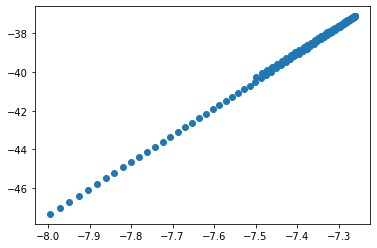

In [7]:
xs = np.linspace(0, 1, 100)
vals_stan = []
vals_pints = []
for x in xs:
    a_params = np.copy(params)
    a_params[0] = x
    vals_stan.append(stanmodel(a_params))
    vals_pints.append(pintsmodel(a_params))
plt.plot(vals_stan, vals_pints, 'o')
plt.show()

## Non-centered model

To speed things up, we can move to Stan's non-centered parameterisation. (Pints also has a version of this model: ) This model introduces auxillary variables $\tilde{\theta}_j$ which ensure the joint distribution: $p(\mu,\tau, \boldsymbol{\theta})$ remains the same, but is easier to sample from.

In [12]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

Instantiate Pints version of non-centered Stan model.

In [13]:
stanmodel = pints.interfaces.StanLogPDF(stan_code=code,
                                        stan_data=model.data())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8f9e8bb354ab461436bb51d935571d NOW.


Compiling Stan model then test running...


Stan model compiled and runs ok...ignore various warnings.


/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Retry sampling, this time with the non-centered parameterisation.

In [19]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(200)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0         0         0.333     0          0:00.0
2     164    0.25      0.25      0.5       0.25       0:00.0
3     244    0.4       0.2       0.6       0.4        0:00.0
200   16004  0.916     0.881     0.891     0.901      0:02.6
400   32004  0.905     0.858209  0.853     0.918      0:05.2
600   48004  0.912     0.827     0.885     0.905      0:07.7
800   64004  0.92      0.788     0.892     0.899      0:10.3
1000  80004  0.924     0.812     0.866     0.897      0:12.9
1200  96004  0.917     0.798     0.872     0.875208   0:15.4
1400  112004  0.921     0.815     0.825     0.869      0:18.0
1600  128004  0.918     0.829     0.809     0.846      0:20.7
1800  144004  0.896     0.835     0.81      0.841      0:23.3
2000  159924  0.879     0.812     0.823     0.844    

Get back original parameter values: $\theta_j = \mu + \tilde{\theta}_j \tau$.

In [20]:
full_chains_transformed = []
for i in range(len(full_chains)):
    mu = full_chains[i][:, 0]
    tau = full_chains[i][:, 1]
    theta_tilde_j = full_chains[i][:, 2:]
    full_chains_transformed.append(
        np.concatenate((np.transpose(np.vstack((mu, tau))),
                        mu[:, np.newaxis] + (theta_tilde_j * tau[:, np.newaxis])),axis=1))

Aaaaahh, that's better...

In [21]:
results = pints.MCMCSummary(chains=full_chains_transformed,
                            time=(end-start), parameter_names=stanmodel.names())
print(results)

param          mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu             5.19    3.16    -0.57   3.01   5.04   7.52   11.33    1.04    40.94   1.58
tau            5.51    3.04    0.69    2.99   5.33   7.94   11.01    1.05    46.44   1.80
theta_tilde.1  8.09    7.09    -3.43   2.85   7.47   12.50  23.33    1.01    87.46   3.38
theta_tilde.2  5.86    5.70    -3.86   2.15   5.17   8.99   19.37    1.01    139.90  5.41
theta_tilde.3  4.61    6.06    -7.24   0.95   4.06   8.39   17.41    1.02    134.52  5.20
theta_tilde.4  5.86    5.55    -4.05   2.06   5.22   9.38   18.36    1.02    223.54  8.65
theta_tilde.5  3.45    5.06    -6.90   0.46   3.28   6.65   13.49    1.01    177.25  6.86
theta_tilde.6  4.15    5.58    -7.19   0.82   3.90   7.44   16.13    1.02    186.17  7.20
theta_tilde.7  8.08    6.13    -2.33   3.70   7.51   11.77  21.65    1.02    161.0

...much more efficient sampling!

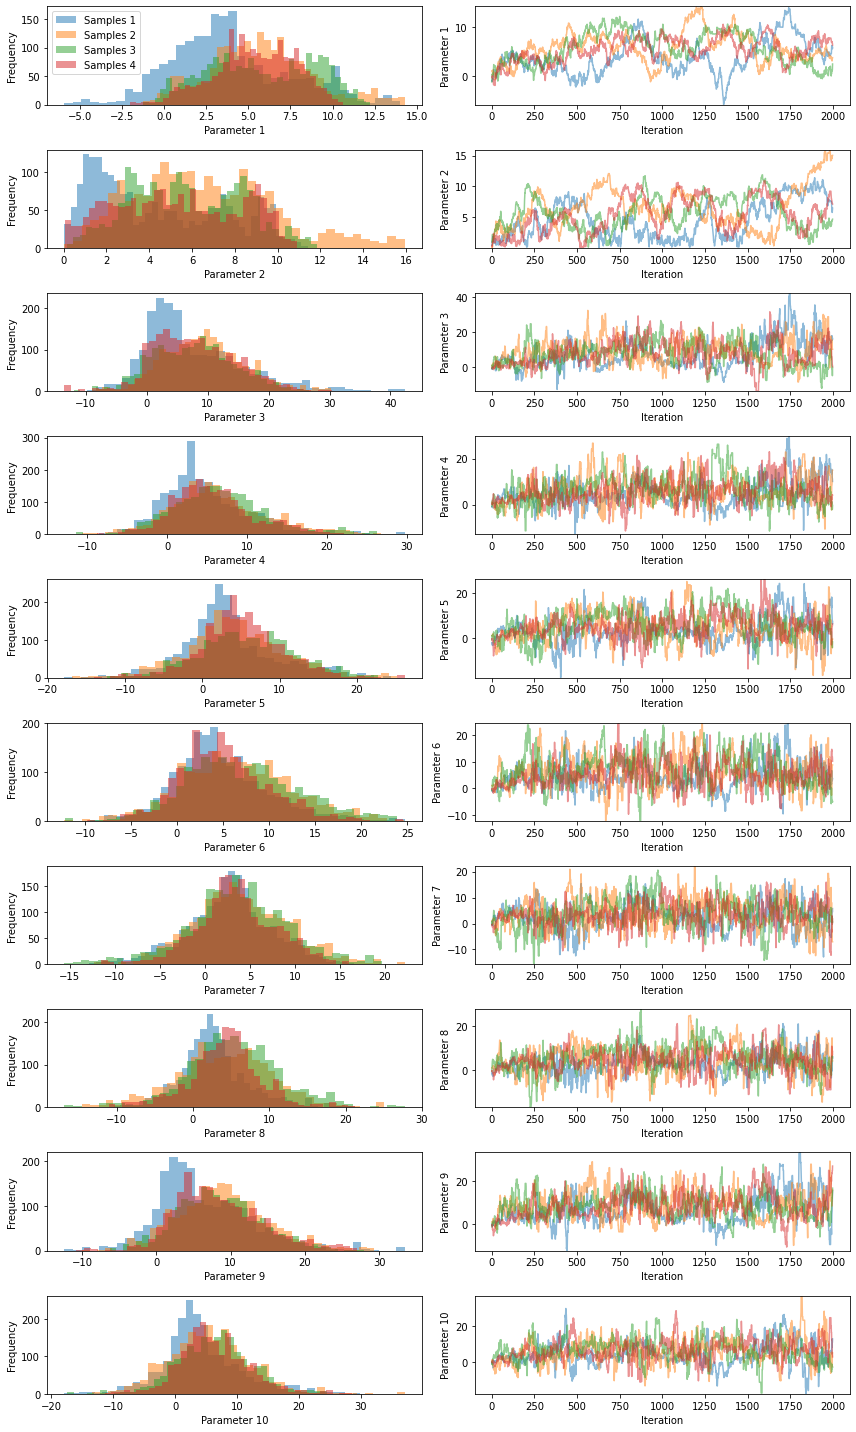

In [22]:
import pints.plot
pints.plot.trace(full_chains_transformed)
plt.show()